In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [40]:
from datetime import datetime as dt
import os

from sklearn.model_selection import train_test_split
from sklearn import preprocessing, impute, metrics
import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf
import altair as alt

# EDA

View EDA notebook <a href="https://www.kaggle.com/code/saraham/titanic-automated-eda/notebook">here</a>.

# Data Preprocessing

In [3]:
train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("../input/titanic/test.csv")

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
# Drop columns except PassengerId, Pclass, Fare, Sex and Survived
train = train[['PassengerId', 'Pclass', 'Fare', 'Sex', 'Survived']]
test = test[['PassengerId', 'Pclass', 'Fare', 'Sex']]

In [7]:
print('Train missing values:', train.isnull().sum())
print('Test missing values:', test.isnull().sum())

Train missing values: PassengerId    0
Pclass         0
Fare           0
Sex            0
Survived       0
dtype: int64
Test missing values: PassengerId    0
Pclass         0
Fare           1
Sex            0
dtype: int64


In [8]:
# Impute missing values with most frequent values
freq_imputer = impute.SimpleImputer(missing_values=np.nan, strategy='most_frequent')
train_imp = freq_imputer.fit_transform(train[['Fare']])
test_imp = freq_imputer.transform(test[['Fare']])

In [9]:
# Concatenate preprocessed train and test sets
train_cleaned = pd.concat([train.drop(columns=['Fare']), pd.DataFrame(train_imp, columns=['Fare'])], axis=1)
test_cleaned = pd.concat([test.drop(columns=['Fare']), pd.DataFrame(test_imp, columns=['Fare'])], axis=1)

In [10]:
train_cleaned.head()

,PassengerId,Pclass,Sex,Survived,Fare
0,1,3,male,0,7.2500
1,2,1,female,1,71.2833
2,3,3,female,1,7.9250
3,4,1,female,1,53.1000
4,5,3,male,0,8.0500


In [11]:
test_cleaned.head()

,PassengerId,Pclass,Sex,Fare
0,892,3,male,7.8292
1,893,3,female,7.0000
2,894,2,male,9.6875
3,895,3,male,8.6625
4,896,3,female,12.2875


In [12]:
# One hot encode categorical columns
train_cat = pd.get_dummies(train[['Sex']])
test_cat = pd.get_dummies(test[['Sex']])

In [13]:
# Concatenate preprocessed dataframes
train_df = pd.concat([train_cleaned.drop(columns=['Sex']), train_cat], axis=1)
test_df = pd.concat([test_cleaned.drop(columns=['Sex']), test_cat], axis=1)

In [14]:
train_df.head()

,PassengerId,Pclass,Survived,Fare,Sex_female,Sex_male
0,1,3,0,7.2500,0,1
1,2,1,1,71.2833,1,0
2,3,3,1,7.9250,1,0
3,4,1,1,53.1000,1,0
4,5,3,0,8.0500,0,1


In [15]:
test_df.head()

,PassengerId,Pclass,Fare,Sex_female,Sex_male
0,892,3,7.8292,0,1
1,893,3,7.0000,1,0
2,894,2,9.6875,0,1
3,895,3,8.6625,0,1
4,896,3,12.2875,1,0


In [16]:
# Split into features and label
feature = train_df.drop(columns = ['Survived', 'PassengerId'])
label = train_df[['Survived']]

In [17]:
# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(feature, label, test_size=0.2, random_state=1, stratify=label)

In [18]:
X_train.head()

,Pclass,Fare,Sex_female,Sex_male
368,3,7.750,1,0
542,3,31.275,1,0
49,3,17.800,1,0
667,3,7.775,0,1
297,1,151.550,1,0


In [19]:
y_train.value_counts()

Survived
0           439
1           273
dtype: int64

In [52]:
# Transform data
scaler = preprocessing.RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(test_df.drop(columns=['PassengerId']))

# Building Model

Goal: Titanic passangers survival classification.

Classifier that we will explore using Grid Search CV:
1. tree.DecisionTreeClassifier
2. tree.ExtraTreeClassifier
3. svm.SVC
4. linear_model.LogisticRegression
5. neighbors.KNeighborsClassifier
6. ensemble.RandomForestClassifier
7. neural_network.MLPClassifier

In [21]:
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

In [23]:
model_params = {
    
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'splitter': ['random', 'best'],
            'max_features': ['auto', 'sqrt', 'log2']
        }
    },
    
    'ExtraTreeClassifier': {
        'model': ExtraTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'splitter': ['random', 'best'],
            'max_features': ['auto', 'sqrt', 'log2']
        }
    },
    
    'SVC': {
        'model': SVC(),
        'params': {
            'C': [1,2,3,4,5],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'gamma': ['scale', 'auto']
        }
    },
    
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': {
            'solver': ['liblinear'],
            'penalty': ['l1', 'l2'],
            'C': [1,2,3,4,5],
            'multi_class': ['ovr']
        }
    },
    
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3,4,5,6]
        }
    },
    
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'params': {
            'max_depth': [4,5,6],
            'n_estimators': [100,200,300]
        }
    },
    
    'MLPClassifier': {
        'model': MLPClassifier(max_iter=500),
        'params': {
            'hidden_layer_sizes': [(32,), (64,), (128,)],
            'learning_rate': ['constant', 'invscaling', 'adaptive']
        }
    }

}

In [24]:
scores = []

for model_name, model_params in model_params.items():
    clf =  GridSearchCV(model_params['model'], model_params['params'], cv=5, return_train_score = False)
    clf.fit(X_train_scaled, np.ravel(y_train, order='C'))
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/opt/conda/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

  warnings.warn(some_fits_failed_mess

In [25]:
model_scores = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
model_scores = model_scores.sort_values(by='best_score', ascending=False)

In [32]:
model_scores

,model,best_score,best_params
0,DecisionTreeClassifier,0.814607,"{'criterion': 'entropy', 'max_features': 'log2..."
1,ExtraTreeClassifier,0.813208,"{'criterion': 'entropy', 'max_features': 'auto..."
5,RandomForestClassifier,0.804767,"{'max_depth': 6, 'n_estimators': 200}"
2,SVC,0.794898,"{'C': 1, 'gamma': 'auto', 'kernel': 'poly'}"
4,KNeighborsClassifier,0.790752,{'n_neighbors': 5}
6,MLPClassifier,0.789353,"{'hidden_layer_sizes': (128,), 'learning_rate'..."
3,LogisticRegression,0.778036,"{'C': 2, 'multi_class': 'ovr', 'penalty': 'l1'..."


In [34]:
# Best model parameters
model_scores[model_scores.index==0]['best_params'][0]

{'criterion': 'entropy', 'max_features': 'log2', 'splitter': 'random'}

In [38]:
model = DecisionTreeClassifier(criterion='entropy', max_features='log2', splitter='random')
model.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', max_features='log2',
                       splitter='random')

In [48]:
pred_val = model.predict(X_val_scaled)
print('Classification report on validation set:')
print(metrics.classification_report(y_val, pred_val, target_names=['No', 'Yes']))

Classification report on validation set:
              precision    recall  f1-score   support

          No       0.84      0.89      0.87       110
         Yes       0.81      0.74      0.77        69

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



Confusion Matrix on validation set:


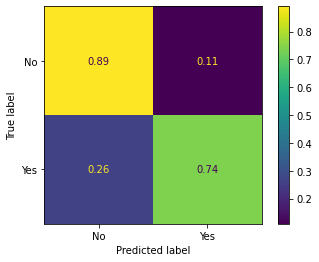

In [49]:
cm = metrics.confusion_matrix(y_val, pred_val, normalize='true')
disp_cm = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
print('Confusion Matrix on validation set:')
disp_cm.plot()

# Prediction on test set

In [54]:
pred_test = model.predict(X_test_scaled)
pred_test

array([0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [59]:
test_submission = pd.concat([test_df[['PassengerId']], pd.DataFrame(pred_test, columns=['Survived'])], axis=1)
test_submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [60]:
test_submission.to_csv('submission.csv', index=False)